# Obesity Classification with XGBoost

In [1]:
# source: https://archive.ics.uci.edu/dataset/544/estimation+of+obesity+levels+based+on+eating+habits+and+physical+condition

## 1. Import libraries required

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler, label_binarize
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score, roc_curve
)
from sklearn.metrics import ConfusionMatrixDisplay

np.random.seed(42)

## 2. Read data and map the target

In [3]:
obesity = pd.read_csv("obesity.csv")
# change the target name from "NObeyesdad" to "target"
obesity.rename(columns={"NObeyesdad": "Target"}, inplace=True)

target_map = {
    "Insufficient_Weight": 0,
    "Normal_Weight":       1,
    "Overweight_Level_I":  2,
    "Overweight_Level_II": 3,
    "Obesity_Type_I":      4,
    "Obesity_Type_II":     5,
    "Obesity_Type_III":    6
}

obesity["Target"] = obesity["Target"].map(target_map)

## 3. Divide categorical and numerical features then split data into train and test

In [4]:
X = obesity.drop(columns=["Target"])
y = obesity["Target"]

num_features = X.select_dtypes(include=['int64', 'float64']).columns
cat_features = X.select_dtypes(include=['object', 'category']).columns

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## 4. Preprocessing by scaling the numerical features and one hot encoding for categorical features

In [5]:
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_features),
        ('cat', categorical_transformer, cat_features)
    ]
)

## 5. Create model pipeline

In [6]:
xgb_clf = XGBClassifier(
    objective='multi:softprob',
    eval_metric='mlogloss',
    random_state=42
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', xgb_clf)
])

## 6. Hyperparameter tunning

In [7]:
param_grid = {
    'classifier__n_estimators': [50, 75, 100, 150, 200],
    'classifier__max_depth': [3, 4, 5],
    'classifier__learning_rate': [0.001, 0.005, 0.01, 0.015],
    'classifier__subsample': [0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1],
    'classifier__colsample_bytree': [0.7, 0.75, 0.8, 0.85, 0.9]
}

grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring='accuracy',
    verbose=2,
    n_jobs=-1
)

print("Running Grid Search for XGBoost hyperparameters...")
grid_search.fit(X_train, y_train)

print("\n Selecte the best parameters:")
print(grid_search.best_params_)
best_model = grid_search.best_estimator_

Running Grid Search for XGBoost hyperparameters...
Fitting 5 folds for each of 2100 candidates, totalling 10500 fits

 Selecte the best parameters:
{'classifier__colsample_bytree': 0.75, 'classifier__learning_rate': 0.015, 'classifier__max_depth': 5, 'classifier__n_estimators': 200, 'classifier__subsample': 0.9}


## 7. Predict by using the best model

In [8]:
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)

## 8. Calculate the metrics: accuracy, recall, precision and f1

In [9]:
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average='macro')
rec = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

print("\n Performance Metrics:")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision (macro): {prec:.4f}")
print(f"Recall (macro):    {rec:.4f}")
print(f"F1-score (macro):  {f1:.4f}")


📊 Performance Metrics:
Accuracy:  0.9314
Precision (macro): 0.9338
Recall (macro):    0.9286
F1-score (macro):  0.9303


## 9. Confusion matrix

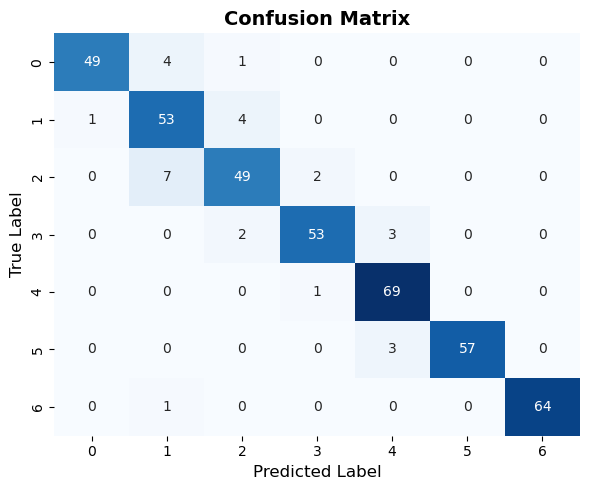

In [10]:
plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Confusion Matrix", fontsize=14, weight='bold')
plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.tight_layout()
plt.show()

## 10. ROC AUC Curve

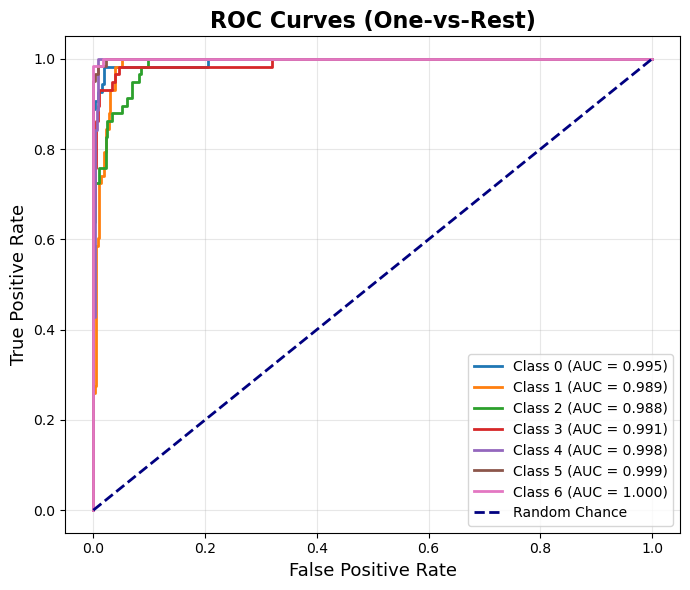

In [11]:
n_classes = len(np.unique(y))
y_test_bin = label_binarize(y_test, classes=np.unique(y))

plt.figure(figsize=(7, 6))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
    auc_score = roc_auc_score(y_test_bin[:, i], y_proba[:, i])
    plt.plot(fpr, tpr, lw=2, label=f'Class {i} (AUC = {auc_score:.3f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Chance')
plt.title('ROC Curves (One-vs-Rest)', fontsize=16, weight='bold')
plt.xlabel('False Positive Rate', fontsize=13)
plt.ylabel('True Positive Rate', fontsize=13)
plt.legend(loc='lower right', fontsize=10, frameon=True)
plt.grid(alpha=0.3)
plt.tight_layout()

save_path = f"ROC_AUC_XGBoost.png"
plt.savefig(save_path, dpi=300, bbox_inches="tight")
plt.show()

## 11. SHAP features importance

C:\Users\ekadw\anaconda3\envs\BookTimeSeries\Lib\site-packages\shap\plots\_beeswarm.py:723: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  summary_legacy(
C:\Users\ekadw\anaconda3\envs\BookTimeSeries\Lib\site-packages\shap\plots\_beeswarm.py:743: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  summary_legacy(
C:\Users\ekadw\anaconda3\envs\BookTimeSeries\Lib\site-packages\shap\plots\_beeswarm.py:743: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  summary_legacy

<Figure size 1000x700 with 0 Axes>

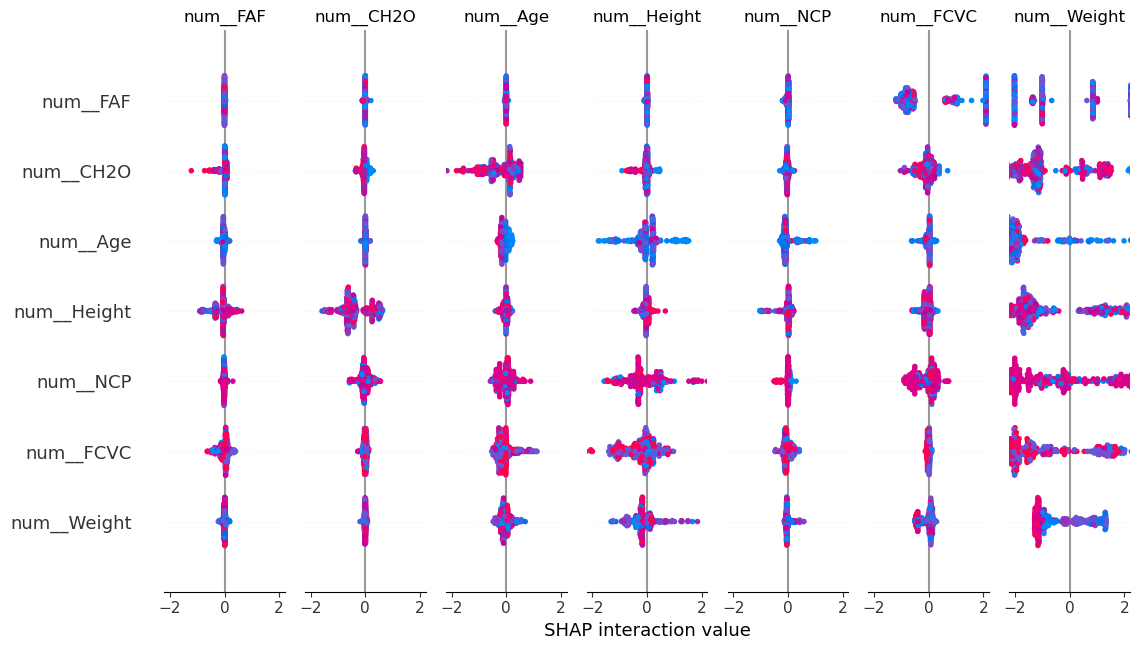

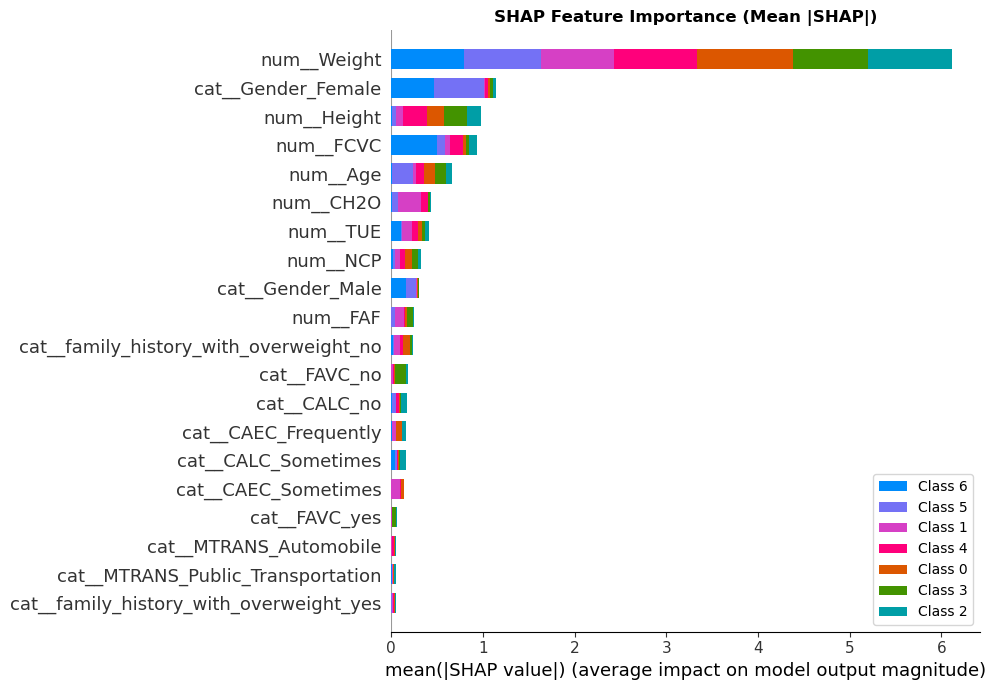

In [12]:
import shap
import os

# Create folder for SHAP plots 
os.makedirs("shap_plots", exist_ok=True)

# Extract trained components from best pipeline 
fitted_preprocessor = best_model.named_steps['preprocessor']
xgb_model = best_model.named_steps['classifier']

# Transform test data using fitted preprocessor 
X_test_t = fitted_preprocessor.transform(X_test)
feature_names = fitted_preprocessor.get_feature_names_out()

# Initialize SHAP TreeExplainer 
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test_t)

# Handle multiclass 
is_multiclass = isinstance(shap_values, list)
if is_multiclass:
    n_classes = len(shap_values)
    class_labels = list(np.unique(y))
    print(f"Detected multiclass problem with {n_classes} classes: {class_labels}")
else:
    shap_values = [shap_values]
    class_labels = ['Class_0']
    n_classes = 1

# Create reproducible random generator 
rng = np.random.default_rng(42)

# Loop through classes for SHAP plots 
for i, class_name in enumerate(class_labels):
    # Beeswarm Plot (Feature Contribution per Sample) 
    plt.figure(figsize=(10, 7))
    shap.summary_plot(
        shap_values[i],
        X_test_t,
        feature_names=feature_names,
        show=False,
        plot_size=(10, 7),
        rng=rng
    )
    #plt.title(f"SHAP Beeswarm", fontsize=12, weight='bold')
    plt.tight_layout()
    plt.savefig(f"shap_plots/shap_beeswarm_{class_name}.png", dpi=400, bbox_inches='tight')
    plt.show()

    # Bar Plot (Mean Absolute SHAP Importance) 
    plt.figure(figsize=(10, 7))
    shap.summary_plot(
        shap_values[i],
        X_test_t,
        feature_names=feature_names,
        plot_type="bar",
        show=False,
        plot_size=(10, 7),
        rng=rng
    )
    plt.title(f"SHAP Feature Importance (Mean |SHAP|)", fontsize=12, weight='bold')
    plt.tight_layout()
    plt.savefig(f"shap_plots/shap_bar_{class_name}.png", dpi=400, bbox_inches='tight')
    plt.legend(loc='lower right')
    plt.show()

    # Compute mean absolute SHAP per feature 
    mean_abs_shap = np.abs(shap_values[i]).mean(axis=0)

    # If 2D, average across classes or flatten
    if mean_abs_shap.ndim > 1:
        mean_abs_shap = mean_abs_shap.mean(axis=0)

    # Ensure same length between SHAP values and feature names
    n_features = len(feature_names)
    n_shap = mean_abs_shap.shape[0]

    if n_shap != n_features:
        feature_names = (
            xgb_model.feature_names_in_[:n_shap]
            if hasattr(xgb_model, "feature_names_in_")
            else feature_names[:n_shap]
        )

    # Create dataframe and save top 10 
    top_features = pd.DataFrame({
        'Feature': feature_names,
        'Mean|SHAP|': mean_abs_shap
    })

    top_features = top_features.sort_values(by='Mean|SHAP|', ascending=False).head(10)
    csv_path = f"shap_plots/top10_features_{class_name}.csv"
    top_features.to_csv(csv_path, index=False)